In [1]:
%load_ext autoreload
%autoreload 2

## Medchem

Medchem is a package for applying general filtering rules on a set of molecules to ensure they have drug-like properties.

In this tutorial, we will apply various filtering on an example dataset to get highlight the package API

### Setup

In [11]:
import datamol as dm
import random
import numpy as np
from loguru import logger

data = dm.data.freesolv().sample(100)
smiles_list = data.smiles.values

In [12]:
from medchem.filter import lead
from medchem.demerits import score
from medchem.novartis import NovartisFilters
from medchem.alerts import AlertFilters

### Using the filter module

The filter module provides a variety of two types of filters:
-  `generic`: custom filtering based on some given molecule properties such as number of atoms, presence of specific atom type, etc
-  `lead`: filtering based on structural motifs that are known to either be toxic, reactive, unstable or frequent false positive

In [13]:
# common filters including pains, brenk, nih, zinc
lead.common_filter(smiles_list, brenk=True, nih=True)

array([ True, False, False, False, False, False, False, False, False,
       False, False,  True,  True, False, False,  True, False,  True,
       False, False,  True, False,  True, False, False,  True, False,
       False, False,  True, False, False,  True,  True,  True,  True,
        True,  True, False,  True, False,  True,  True, False, False,
        True,  True, False,  True,  True, False, False, False,  True,
        True, False, False,  True, False, False,  True, False,  True,
        True,  True, False, False, False,  True,  True,  True,  True,
       False, False,  True, False, False, False,  True, False, False,
        True, False, False,  True,  True,  True, False, False, False,
       False, False,  True,  True, False, False, False,  True, False,
       False])

In [20]:
# filtering based on some commons alerts + additional lead like rules
lead.alert_filter(smiles_list, alerts=["Glaxo", "BMS"], rule_dict=dict(MW=[0, 100]))

array([False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True, False,  True, False, False,
       False, False, False,  True, False, False, False, False, False,
        True, False,  True, False, False, False,  True,  True, False,
        True, False, False, False, False, False, False, False, False,
       False,  True,  True,  True, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False,  True, False,
       False, False,  True, False, False,  True,  True, False, False,
       False, False, False, False, False,  True, False, False,  True,
       False,  True,  True, False, False, False, False,  True, False,
       False])

In [22]:
# filtering based on NIBR screening deck process described in
# "Evolution of Novartis' small molecule screening deck design" by Schuffenhauer, A. et al. J. Med. Chem. (2020), 
# https://dx.doi.org/10.1021/acs.jmedchem.0c01332. 
lead.screening_filter(smiles_list, return_idx=True)

array([ 0,  1,  2,  3,  4,  5,  6,  8,  9, 11, 12, 13, 15, 16, 17, 18, 19,
       20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 41, 42, 43, 45, 46, 48, 49, 50, 51, 53, 54, 55, 57, 58, 60,
       61, 62, 63, 64, 65, 67, 68, 69, 70, 71, 72, 73, 74, 75, 77, 78, 79,
       80, 81, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [37]:
# Filter based on the demerit scoring of Eli Lilly
test_config = {
    "output": "test",
    "min_atoms": 10,
    "soft_max_atoms": 30,
    "hard_max_atoms": 50,
    "smarts": [],
    "nodemerit": False,
    "dthresh": 160,
    "odm": [],
    "okiso": False,
    "noapdm": False,
}
lead.demerit_filter(smiles_list, max_demerits=160, return_idx=True, **test_config)



array([20, 35, 60, 62, 64, 69, 73, 79, 81, 85, 88, 96, 98])

### Advanced options

The advanced options allow a better control over the filtering process. They also provide more information on the issues with the molecules.

#### AlertFilter

These are the underlying filters called by `lead.alert_filter`. In the output, the compound status is indicated as either `"Exclude"` or `"Ok"`.

In [41]:
filter_obj = AlertFilters(alerts_set=["inpharmatica", "SureChEMBL"])
out = filter_obj(smiles_list)
out

_smiles   status  \
0                         CCOC(=O)CC       Ok   
1                            CCCCCCO       Ok   
2                        CC(C)CCOC=O  Exclude   
3                      COc1ccc(N)cc1  Exclude   
4                   Clc1cccc(Cl)c1Cl       Ok   
..                               ...      ...   
95                     CCCCCc1ccccc1       Ok   
96           FC(F)[C@@H](F)Oc1ccccc1       Ok   
97                         CN1CCCCC1       Ok   
98     COC(=O)c1ccc([N+](=O)[O-])cc1       Ok   
99  CCOP(=S)(OCC)Oc1nc(Cl)c(Cl)cc1Cl  Exclude   

                                              reasons       MW    LogP  HBD  \
0                                                None  102.133  0.9595    0   
1                                                None  102.177  1.5590    1   
2                  formate_formide; Filter38_aldehyde  116.160  1.2055    0   
3                                             analine  123.155  1.2774    1   
4                                                None  181.449  3.6468    0   
..                                                ...      ...     ...  ...   
95                                               None  148.249  3.4193    0   
96                                               None  176.137  2.6261    0   
97                                               None   99.177  1.1021    0   
98                                               None  181.147  1.3814    0   
99  Active_Phosphate; halo-pyridine,_-diazoles_and...  350.591  4.7181    0   

    HBA   TPSA  
0     2  26.30  
1     1  20.23  
2     2  26.30  
3     2  35.25  
4     0   0.00  
..  ...    ...  
95    0   0.00  
96    1   9.23  
97    1   3.24  
98    4  69.44  
99    5  40.58  

[100 rows x 8 columns]

#### NovartisFilter

These are the underlying filters called by `lead.screening_filter`. 

Here is an explanation of the output:
- **status**: one of `["Exclude", "Flag", "Annotations", "Ok"]` (ordered by quality). Generally, you can keep anything without the "Exclude" label, as long as you also apply a maximum severity score for compounds that collects too many flags.
- **covalent**: number of potentially covalent motifs contained in the compound
- **severity**: how severe are the issues with the molecules:
      - `0`: compound has no flags, might have annotations;
      - `1-9`:  number of flags the compound raises;
      - `>= 10`:  default exclusion criterion used in the paper
- **special_mol**: whether the compound/parts of the compound belongs to a special class of molecules (e.g peptides, glycosides, fatty acid). In that case, you should review the rejection reasons.

In [43]:
filter_obj = NovartisFilters()
out = filter_obj(smiles_list)
out

_smiles       status  \
0                         CCOC(=O)CC           Ok   
1                            CCCCCCO           Ok   
2                        CC(C)CCOC=O           Ok   
3                      COc1ccc(N)cc1         Flag   
4                   Clc1cccc(Cl)c1Cl         Flag   
..                               ...          ...   
95                     CCCCCc1ccccc1           Ok   
96           FC(F)[C@@H](F)Oc1ccccc1  Annotations   
97                         CN1CCCCC1           Ok   
98     COC(=O)c1ccc([N+](=O)[O-])cc1  Annotations   
99  CCOP(=S)(OCC)Oc1nc(Cl)c(Cl)cc1Cl         Flag   

                                              reasons  severity  covalent  \
0                                                None         0       NaN   
1                                                None         0       NaN   
2                                                None         0       NaN   
3                             aniline_no_alkyl_min(1)         1       0.0   
4   halogen_aromatic_count_3_min(3); polyhalogenat...         1       0.0   
..                                                ...       ...       ...   
95                                               None         0       NaN   
96                       alpha_halo_heteroatom_min(1)         0       0.0   
97                                               None         0       NaN   
98                               nitro_count_1_min(1)         0       0.0   
99  halogen_aromatic_count_3_min(3); PO3 _groups_m...         1       0.0   

    special_mol  
0           NaN  
1           NaN  
2           NaN  
3           0.0  
4           0.0  
..          ...  
95          NaN  
96          0.0  
97          NaN  
98          0.0  
99          0.0  

[100 rows x 6 columns]

#### Demerits scoring

Demerit scoring uses the Eli Lilly filter rules. Those are complex rules, that can be customized in any way you wish. 

The following "information" will be computed and added as columns to a DataFrame for each run:

- **status**: this was added for compatibility and has values `"Exclude"`, `"Flag"` or `"Ok"` based on whether the molecules should be rejected or not.
- **rejected** : whether the molecule pass the filter or was rejected
- **reasons**: the reasons why the molecule was rejected if available
- **demerit_score** a demerit score for molecules. The lower the better. A cutoff (parameter) is used to reject molecule with too many demerits
- **step**: step of the pipeline where molecule was filtered out, if available



In [3]:
from molfeat.calc import RDKitDescriptors2D

calc = RDKitDescriptors2D()
calc(mol2d)

Using backend: pytorch


array([ 6.82415895, -1.37469136,  6.82415895, ...,  0.        ,
        0.        ,  3.        ])

### Using the trans module

Almost all transformers in `molfeat` are subclass of `MoleculeTransformer` which in turns implements `BaseFeaturizer` interface.  The base interface and transformer classes ensure some compatibility with the `scikit-learn` estimators as well as implementing commons features such as `__len__` and `collate_fn`. 



`MoleculeTransformer` accepts as input a callable that represents the featurizer which would be applied on each indiviual molecule. It can compute features under a parallelization mode and can handle datatype conversion. The class also offers too endpoints for featurizing a set of molecules ( `transform` and  `__call__`). The advantage of using `__call__` is the return of both the featurized vector and the ids where featurization was successful.


Note however that placing torch tensor to the GPU is not handled forcing users to appropriately optimize their code.

In [4]:
import torch
from molfeat.trans.fp import MoleculeTransformer

#### Checking the effect of parallelization

In [6]:
%%timeit 
## Using the transformer with an input featurizer

trans = MoleculeTransformer(calc, n_jobs=4, verbose=True, dtype=torch.float)
X = trans(data, enforce_dtype=True)

1.36 s ± 152 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
%%timeit 
## Using the transformer with an input featurizer

trans = MoleculeTransformer(calc, n_jobs=1, verbose=True, dtype=torch.float)
X = trans(data, enforce_dtype=True)

3.96 s ± 459 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
# pretty printing of the transformer
trans = MoleculeTransformer(calc, n_jobs=1, verbose=True, dtype=torch.float)

print(trans)

MoleculeTransformer(dtype=torch.float32,
                    featurizer=<molfeat.calc.descriptors.RDKitDescriptors2D object at 0x7ff671945a50>)


#### Providing a custom featurizer

In [10]:
from rdkit.Chem.rdMolDescriptors import CalcNumHeteroatoms
def custom_featurizer(mol):
    """My custom featurizer"""
    mol = dm.to_mol(mol)
    return [mol.GetNumAtoms(), mol.GetNumBonds(), CalcNumHeteroatoms(mol), random.random()]

In [11]:
trans = MoleculeTransformer(custom_featurizer, n_jobs=0, verbose=True, dtype=float)
trans.transform(data[:10], ignore_errors=False)

[array([8.        , 7.        , 1.        , 0.17467059]),
 array([9.        , 9.        , 3.        , 0.30310511]),
 array([6.        , 5.        , 0.        , 0.36258741]),
 array([9.        , 8.        , 2.        , 0.45692842]),
 array([8.        , 8.        , 1.        , 0.86004914]),
 array([10.        , 11.        ,  1.        ,  0.23938029]),
 array([7.        , 7.        , 2.        , 0.43964778]),
 array([12.        , 12.        ,  8.        ,  0.37524299]),
 array([5.        , 4.        , 1.        , 0.58293156]),
 array([6.        , 5.        , 1.        , 0.23565393])]

#### Providing a name for a common featurizer

In [12]:
trans = MoleculeTransformer("ecfp", n_jobs=0, verbose=True, dtype=float, length=32)
trans(data[:10], ignore_errors=False, enforce_dtype=True)

array([[0., 1., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 1., 0., 0.]])

#### Fitting a transformer on a dataset to remove columns with nan values.

If you want to keep such columns or perform your own imputation, you should handle that at internal featurizer, or just not call `fit`

In [17]:
from molfeat.calc import MordredDescriptors

# 2D mordred descriptors
desc = MordredDescriptors(replace_nan=False, ignore_3D=True)
trans = MoleculeTransformer(desc, verbose=True, dtype=float, length=32)
# has nan
X = trans(data[:10], ignore_errors=False, enforce_dtype=True)
print("Num Columns before fitting:", len(trans.columns), "\nNum of nan before fitting:", np.isnan(X).sum(), "\n-------")
# fitting
trans.fit(data)
X = trans(data[:10], ignore_errors=False, enforce_dtype=True)
print("Num Columns after fitting:", len(trans.columns), "\nNum of nan after fitting:", np.isnan(X).sum(), "\n-------")

Num Columns before fitting: 1613 
Num of nan before fitting: 2774 
-------
Num Columns after fitting: 1066 
Num of nan after fitting: 0 
-------


### Training a scikit-learning pipeline to predict solubility

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [19]:
df = dm.data.freesolv()
X, y = df["smiles"], df["expt"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

feat = MoleculeTransformer("desc2d")
pipe = Pipeline([('feat', feat), ('scaler', StandardScaler()), ('rf', RandomForestRegressor())])
pipe.fit(X_train, y_train)

Pipeline(steps=[('feat',
                 MoleculeTransformer(featurizer=<molfeat.calc.descriptors.RDKitDescriptors2D object at 0x7ff630220510>)),
                ('scaler', StandardScaler()), ('rf', RandomForestRegressor())])

In [20]:
pipe.score(X_test, y_test)

0.9020583487672389

/Users/manu/.miniconda/envs/molfeat/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='expt', ylabel='rf_pred'>

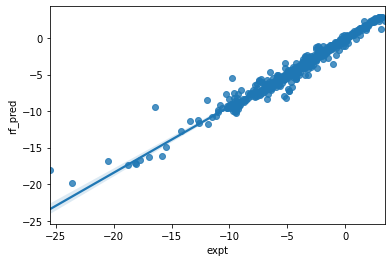

In [21]:
import seaborn as sns
ypred = pipe.predict(X)
df["rf_pred"] = ypred

sns.regplot("expt", "rf_pred", data=df)